In [1]:
%matplotlib inline
import json
import glob
import time

import numpy as np
import pandas as pd
import pylab
import seaborn

In [2]:
def at_stop(d):
    journey = d['MonitoredVehicleJourney']
    call = journey.get('MonitoredCall')
    if not call:
        return False
    
    distances = call['Extensions']['Distances']
    presentable_distance = distances['PresentableDistance']
    return presentable_distance.strip() == 'at stop'

vehicle_calls_by_vehicle = {}
for fname in glob.glob('/Users/flamholz/Dropbox/b41_data/*.json'):
    with open(fname) as f:
        data = json.load(f)
        vehicle_monitoring = data['Siri']['ServiceDelivery']['VehicleMonitoringDelivery']
        vehicle_activity = vehicle_monitoring[0]['VehicleActivity']

        for d in vehicle_activity:
            if not at_stop(d):
                continue
                
            journey = d['MonitoredVehicleJourney']
            vehicle_ref = journey['VehicleRef']
            destination = journey['DestinationName']
            calls_by_dest = vehicle_calls_by_vehicle.setdefault(vehicle_ref, {})
            calls_by_dest.setdefault(destination, []).append(d)


In [3]:
def get_ts(d):
    tstring = d['RecordedAtTime']
    fmt = '%Y-%m-%dT%H:%M:%S.000-04:00'
    ts = time.mktime(time.strptime(tstring, fmt))
    d['_timestamp'] = ts  # stash in dict
    d['_timestring'] = tstring
    return ts

def get_station_name(d):
    journey = d['MonitoredVehicleJourney']
    return journey['MonitoredCall']['StopPointName'], journey['MonitoredCall']['StopPointRef']

def is_station(d, station_ids):
    journey = d['MonitoredVehicleJourney']
    stop_ref = journey['MonitoredCall']['StopPointRef']
    return stop_ref in station_ids

stop_ids = {'kings_plaza': ['MTA_303215', 'MTA_801144'],
            'livingston_smith': ['MTA_303259', 'MTA_303290']}
dests_to_endpoints = {'LTD DNTWN BKLYN CADMAN PLZ via FLATBUSH': ('kings_plaza', 'livingston_smith'),
                      'DNTWN BKLYN CADMAN PLZ via FLATBSH': ('kings_plaza', 'livingston_smith'),
                      'LTD KINGS PLAZA via FLATBUSH': ('livingston_smith', 'kings_plaza'),
                      'KINGS PLAZA via FLATBSH': ('livingston_smith', 'kings_plaza'),
                      'BERGEN BCH VETERANS AV via FLATBSH': (None, None),
                      'LTD BERGEN BCH VETERANS AV via FLATBUSH': (None, None),
                      'NOSTRND AV': (None, None),
                      'EMPIRE BL': (None, None),
                      'LTD EMPIRE BLVD': (None, None)}

In [4]:
column_names = ['VehicleID', 'Destination', 'StartStationName', 'StartStationRef',
                'EndStationName', 'EndStationRef', 'StartTime', 'EndTime',
                'DurationSeconds', 'DurationMinutes']
trip_duration_rows = []

for i, (vehicle_id, ds) in enumerate(vehicle_calls_by_vehicle.iteritems()):
    for dest, calls in ds.iteritems():
        start, stop = dests_to_endpoints[dest]
        if not start or not stop:
            continue

        starts = stop_ids[start]
        stops = stop_ids[stop]

        sorted_calls = sorted(calls, key=get_ts)
        is_start = np.array([is_station(c, starts) for c in calls])
        is_stop = np.array([is_station(c, stops) for c in calls])
        any_start = np.any(is_start)
        any_stop = np.any(is_stop)
        if not any_start or not any_stop:
            continue
        
        start_idxs = np.where(is_start)[0]
        stop_idxs = np.where(is_stop)[0]
        start_idx = start_idxs.min()
        #print vehicle_id, dest
        while True:
            # Find the next terminus that is after the trip origin
            stop_above_start = stop_idxs[stop_idxs > start_idx]
            if not stop_above_start.size:
                break
            stop_idx = stop_above_start[0]
            
            start_call = sorted_calls[start_idx]
            end_call = sorted_calls[stop_idx]
            start_name, start_ref = get_station_name(start_call)
            end_name, end_ref = get_station_name(end_call)
            
            duration = end_call['_timestamp'] - start_call['_timestamp']
            row = [vehicle_id, dest,
                   start_name, start_ref,
                   end_name, end_ref,
                   start_call['_timestring'], end_call['_timestring'],
                   duration, duration/60.0]
            trip_duration_rows.append(row)
            
            start_above_stop = start_idxs[start_idxs > stop_idx]
            if not start_above_stop.size:
                break
            start_idx = start_above_stop[0]

In [5]:
trip_durations_df = pd.DataFrame(trip_duration_rows, columns=column_names)
trip_durations_df.to_csv('b41_trip_durations.csv', index=False)

In [9]:
thresholds = np.arange(60,200,10)

ltd_dtown_mean = []
ltd_dtown_std = []
ltd_dtown_n = []
reg_dtown_mean = []
reg_dtown_std = []
reg_dtown_n = []

ltd_kings_mean = []
ltd_kings_std = []
ltd_kings_n = []

reg_kings_mean = []
reg_kings_std = []
reg_kings_n = []

for th in thresholds:
    filtered_trips = trip_durations_df[trip_durations_df.DurationMinutes < th]
    ltd = filtered_trips[filtered_trips.Destination == 'LTD DNTWN BKLYN CADMAN PLZ via FLATBUSH']
    ltd_dtown_mean.append(ltd.DurationMinutes.mean())
    ltd_dtown_std.append(ltd.DurationMinutes.std())
    ltd_dtown_n.append(ltd.shape[0])
    
    reg = filtered_trips[filtered_trips.Destination == 'DNTWN BKLYN CADMAN PLZ via FLATBSH']
    reg_dtown_mean.append(reg.DurationMinutes.mean())
    reg_dtown_std.append(reg.DurationMinutes.std())
    reg_dtown_n.append(reg.shape[0])
    
    ltd = filtered_trips[filtered_trips.Destination == 'LTD KINGS PLAZA via FLATBUSH']
    ltd_kings_mean.append(ltd.DurationMinutes.mean())
    ltd_kings_std.append(ltd.DurationMinutes.std())
    ltd_kings_n.append(ltd.shape[0])
    
    reg = filtered_trips[filtered_trips.Destination == 'KINGS PLAZA via FLATBSH']
    reg_kings_mean.append(reg.DurationMinutes.mean())
    reg_kings_std.append(reg.DurationMinutes.std())
    reg_kings_n.append(reg.shape[0])

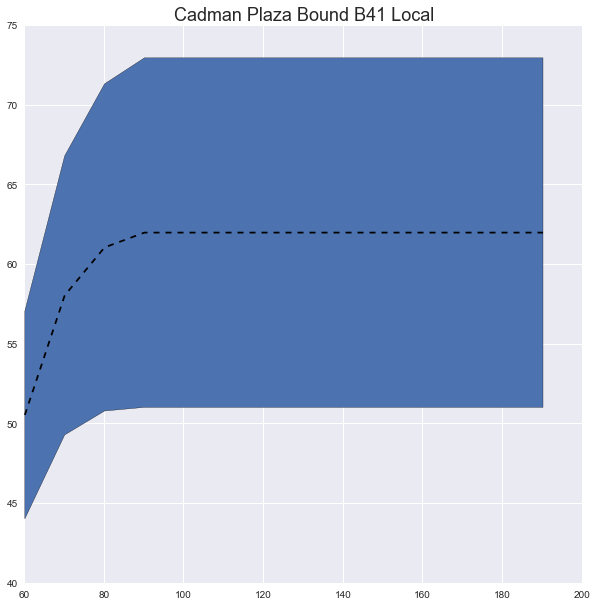

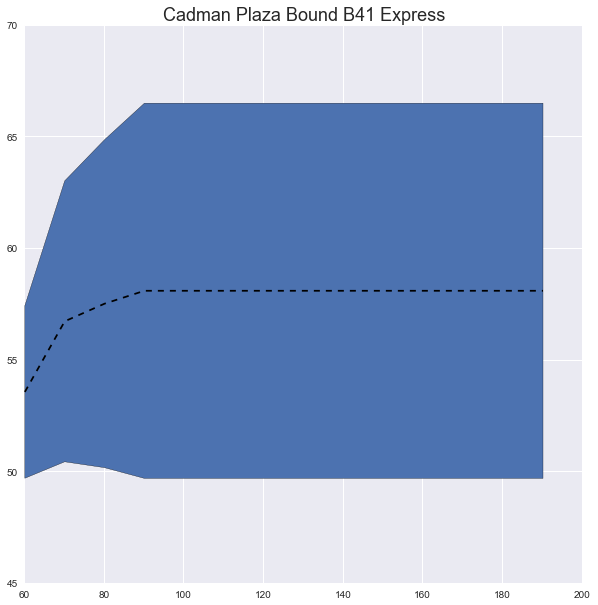

In [7]:
ltd_dtown_mean = np.array(ltd_dtown_mean)
ltd_dtown_std = np.array(ltd_dtown_std)
reg_dtown_mean = np.array(reg_dtown_mean)
reg_dtown_std = np.array(reg_dtown_std)

pylab.figure(figsize=(10,10))
pylab.fill_between(thresholds, reg_dtown_mean - reg_dtown_std, reg_dtown_mean + reg_dtown_std, label='Local')
pylab.plot(thresholds, reg_dtown_mean, 'k--')
pylab.title('Cadman Plaza Bound B41 Local', fontsize=18)
pylab.savefig('cadman_bound_local.png')
pylab.show()

pylab.figure(figsize=(10,10))
pylab.fill_between(thresholds, ltd_dtown_mean - ltd_dtown_std, ltd_dtown_mean + ltd_dtown_std)
pylab.plot(thresholds, ltd_dtown_mean, 'k--')
pylab.title('Cadman Plaza Bound B41 Express', fontsize=18)
pylab.savefig('cadman_bound_exp.png')
pylab.show()

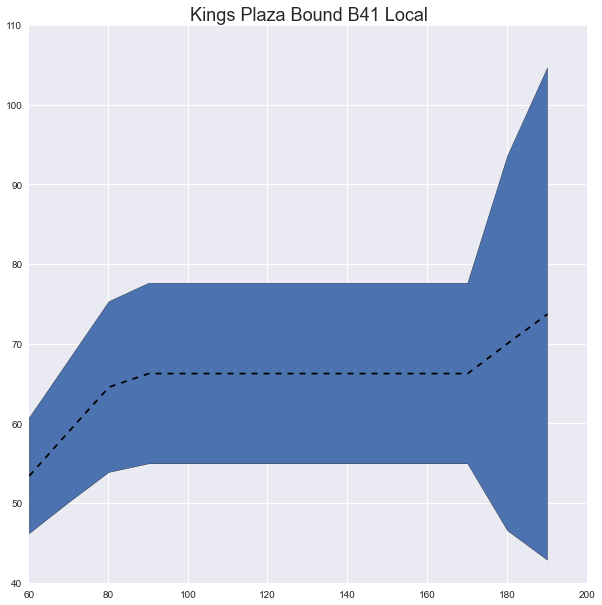

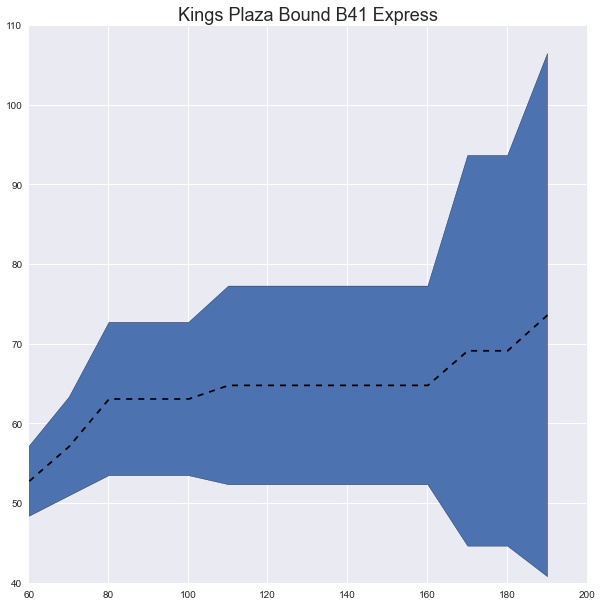

In [8]:
ltd_kings_mean = np.array(ltd_kings_mean)
ltd_kings_std = np.array(ltd_kings_std)
reg_kings_mean = np.array(reg_kings_mean)
reg_kings_std = np.array(reg_kings_std)

pylab.figure(figsize=(10,10))
pylab.fill_between(thresholds, reg_kings_mean - reg_kings_std, reg_kings_mean + reg_kings_std, label='Local')
pylab.plot(thresholds, reg_kings_mean, 'k--')
pylab.title('Kings Plaza Bound B41 Local', fontsize=18)
pylab.savefig('kings_bound_local.png')
pylab.show()

pylab.figure(figsize=(10,10))
pylab.fill_between(thresholds, ltd_kings_mean - ltd_kings_std, ltd_kings_mean + ltd_kings_std)
pylab.plot(thresholds, ltd_kings_mean, 'k--')
pylab.title('Kings Plaza Bound B41 Express', fontsize=18)
pylab.savefig('kings_bound_exp.png')
pylab.show()

In [10]:
thresh = 120
idx = np.where(thresholds == thresh)[0][0]

print 'Cadman bound express'
print 'mean duration %.2f +/- %.2f minutes (N=%d)' % (ltd_dtown_mean[idx], ltd_dtown_std[idx], ltd_dtown_n[idx])
print 'Cadman bound local'
print 'mean duration %.2f +/- %.2f minutes (N=%d)' % (reg_dtown_mean[idx], reg_dtown_std[idx], reg_dtown_n[idx])

print 'Kings plaza bound express'
print 'mean duration %.2f +/- %.2f minutes (N=%d)' % (ltd_kings_mean[idx], ltd_kings_std[idx], ltd_kings_n[idx])
print 'Kings plaza local'
print 'mean duration %.2f +/- %.2f minutes (N=%d)' % (reg_kings_mean[idx], reg_kings_std[idx], reg_kings_n[idx])



Cadman bound express
mean duration 58.13 +/- 8.40 minutes (N=53)
Cadman bound local
mean duration 62.03 +/- 10.96 minutes (N=46)
Kings plaza bound express
mean duration 64.89 +/- 12.46 minutes (N=23)
Kings plaza local
mean duration 66.38 +/- 11.33 minutes (N=29)
